In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
industries=pd.read_excel('./data/LMO_Detailed_Industries_by_NAICS.xlsx')
industries.head(15).tail(10)

,LMO_Detailed_Industry,NAICS
5,Support activities for mining and oil and gas ...,213
6,Mining,212
7,Utilities,22
8,Construction,23
9,"Food, beverage and tobacco manufacturing",311 & 312
10,Wood product manufacturing,321
11,Paper manufacturing,322
12,Primary metal manufacturing,331
13,Fabricated metal product manufacturing,332
14,Machinery manufacturing,333


In [3]:
industries['NAICS']=industries['NAICS'].astype(str).str.replace('&',',')
indust = []
naics = []
for i,row in industries.iterrows():
    x = row['NAICS'].split(',')
    for val in x:
        val = val.strip()
        indust.append(row['LMO_Detailed_Industry'])
        naics.append(val)
x = {'LMO_Detailed_Industry':indust,'NAICS':naics}
industries = pd.DataFrame(x)
display(industries)

,LMO_Detailed_Industry,NAICS
0,Farms,111
1,Farms,112
2,"Fishing, hunting and trapping",114
3,Forestry and logging,113
4,Support activities for agriculture and forestry,115
...,...,...
102,Federal government public administration,911
103,Provincial and territorial public administration,912
104,Local and Indigenous public administration,913
105,Local and Indigenous public administration,914


In [4]:
import glob
files_2 = glob.glob('data/*2NAICS*.csv')
files_3 = glob.glob('data/*3NAICS*.csv')
files_4 = glob.glob('data/*4NAICS*.csv')
print(files_2)

['data\\RTRA_Employ_2NAICS_00_05.csv', 'data\\RTRA_Employ_2NAICS_06_10.csv', 'data\\RTRA_Employ_2NAICS_11_15.csv', 'data\\RTRA_Employ_2NAICS_16_20.csv', 'data\\RTRA_Employ_2NAICS_97_99.csv']


In [5]:
def create_data_based_on_digits(files, four_digits = False):
    """"      
    The function will create a dataframe with the NAICS hiearchy level         
    Args:      
    -----------------------------------------      
    files: list of csv files
    four_digits: bool that checks if its the files containing 4 digits IDs or not.
    Returns:      
    ----------------------------------------      
    final_data: Pandas dataframe        
    """
    ##LOAD THE DATA
    employment = pd.read_csv(files[0])
    for f in files[1:]:
        df = pd.read_csv(f)
        employment = employment.append(df,ignore_index=True)
    print('First time loading the files')
    display(employment)
    if not four_digits:
        ##CLEAN UP THE NAICS NAME AND CODE COLUMN BY SEPERATING THEM 
        naics = employment.NAICS.astype(str)
        naics = naics.astype(str).str.split('[').values
        nc , codes = list(),list()
        for n in naics:
            try:
                nc.append(n[0])
                codes.append(n[1].strip(']').replace('-',','))
            except:
                #Other label in 3 digits files
                codes.append('99999')
        employment['NAICS_CODE'] = codes
        employment['NAICS'] = nc
        #display(employment[employment['NAICS'] == 'Other']) #DEBUG FOR 3 DIGITS FILES
    
        #MERGE THE DATA TO GET THE RTRA DATA WE DESIRE FROM THE RELEVENT INDUSTRIES FILES
        final_data = employment.merge(industries,left_on='NAICS_CODE',right_on='NAICS',how='left')
        final_data = final_data.drop(['NAICS_x','NAICS_y'],axis=1)
        final_data.dropna(inplace=True)
        print('Cleaning the NAICS column and merging the data')
    else:
        employment['NAICS'] = employment.NAICS.astype(str)
        #MERGE THE DATA TO GET THE RTRA DATA WE DESIRE FROM THE RELEVENT INDUSTRIES FILES
        final_data = employment.merge(industries,left_on='NAICS',right_on='NAICS',how='left')
        print('merging the data')
    display(final_data.head())
    #CREATE THE DATETIME INDEX
    final_data['Sdate'] = final_data.SMTH.astype(str) + ' ' + final_data.SYEAR.astype(str)
    final_data['Sdate'] = pd.to_datetime(final_data['Sdate']).dt.strftime('%Y-%m')
    final_data.set_index('Sdate',inplace=True)
    if four_digits:
        final_data = final_data.rename(columns={'NAICS':'NAICS_CODE'})
    final_data = final_data.drop(['SYEAR','SMTH'],axis=1)
    final_data = final_data.dropna()

    print('Fixing the Date index and dropping unecessary rows (having missing values)')
    display(final_data)
            
    return final_data

In [6]:
employment2 = create_data_based_on_digits(files_2,False)
employment3 = create_data_based_on_digits(files_3,False)
employment4 = create_data_based_on_digits(files_4,True)

First time loading the files


,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,Accommodation and food services [72],148000
1,2000,1,"Administrative and support, waste management a...",59250
2,2000,1,"Agriculture, forestry, fishing and hunting [11]",61750
3,2000,1,"Arts, entertainment and recreation [71]",39500
4,2000,1,Construction [23],106250
...,...,...,...,...
5467,1999,12,"Real estate, rental and leasing [53]",37000
5468,1999,12,Retail trade [44-45],230750
5469,1999,12,Transportation and warehousing [48-49],117500
5470,1999,12,Utilities [22],10250


Cleaning the NAICS column and merging the data


,SYEAR,SMTH,_EMPLOYMENT_,NAICS_CODE,LMO_Detailed_Industry
1,2000,1,59250,56,"Business, building and other support services"
4,2000,1,106250,23,Construction
9,2000,1,1000,55,"Business, building and other support services"
12,2000,1,100250,81,"Repair, personal and non-profit services"
15,2000,1,37500,53,Real estate rental and leasing


Fixing the Date index and dropping unecessary rows (having missing values)


,_EMPLOYMENT_,NAICS_CODE,LMO_Detailed_Industry
Sdate,,,
2000-01,59250,56,"Business, building and other support services"
2000-01,106250,23,Construction
2000-01,1000,55,"Business, building and other support services"
2000-01,100250,81,"Repair, personal and non-profit services"
2000-01,37500,53,Real estate rental and leasing
...,...,...,...
1999-12,1250,55,"Business, building and other support services"
1999-12,99500,81,"Repair, personal and non-profit services"
1999-12,37000,53,Real estate rental and leasing


First time loading the files


,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,Aboriginal public administration[914],500
1,2000,1,Accommodation services[721],33750
2,2000,1,Administrative and support services[561],55250
3,2000,1,Air transportation[481],17500
4,2000,1,Ambulatory health care services[621],53000
...,...,...,...,...
28135,1999,12,Utilities[221],10000
28136,1999,12,Warehousing and storage[493],4500
28137,1999,12,Waste management and remediation services[562],4500
28138,1999,12,Water transportation[483],6750


Cleaning the NAICS column and merging the data


,SYEAR,SMTH,_EMPLOYMENT_,NAICS_CODE,LMO_Detailed_Industry
0,2000,1,500,914,Local and Indigenous public administration
1,2000,1,33750,721,Accommodation services
3,2000,1,17500,481,Air transportation
4,2000,1,53000,621,Ambulatory health care services
5,2000,1,22250,713,"Amusement, gambling and recreation industries"


Fixing the Date index and dropping unecessary rows (having missing values)


,_EMPLOYMENT_,NAICS_CODE,LMO_Detailed_Industry
Sdate,,,
2000-01,500,914,Local and Indigenous public administration
2000-01,33750,721,Accommodation services
2000-01,17500,481,Air transportation
2000-01,53000,621,Ambulatory health care services
2000-01,22250,713,"Amusement, gambling and recreation industries"
...,...,...,...
1999-12,14000,485,"Transit, sightseeing, and pipeline transportation"
1999-12,29250,484,Truck transportation
1999-12,4500,493,Warehousing and storage


First time loading the files


,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,1100,500
1,2000,1,1111,0
2,2000,1,1112,2000
3,2000,1,1113,250
4,2000,1,1114,7750
...,...,...,...,...
85567,1999,12,9111,2250
85568,1999,12,9120,28500
85569,1999,12,9130,30250
85570,1999,12,9141,500


merging the data


,SYEAR,SMTH,NAICS,_EMPLOYMENT_,LMO_Detailed_Industry
0,2000,1,1100,500,NaN
1,2000,1,1111,0,NaN
2,2000,1,1112,2000,NaN
3,2000,1,1113,250,NaN
4,2000,1,1114,7750,NaN


Fixing the Date index and dropping unecessary rows (having missing values)


,NAICS_CODE,_EMPLOYMENT_,LMO_Detailed_Industry
Sdate,,,
2000-01,3361,1000,Transportation equipment manufacturing (exclud...
2000-01,3362,2250,Transportation equipment manufacturing (exclud...
2000-01,3363,1250,Transportation equipment manufacturing (exclud...
2000-01,3364,2250,Transportation equipment manufacturing (exclud...
2000-01,3365,0,Transportation equipment manufacturing (exclud...
...,...,...,...
1999-12,6113,13750,Universities
1999-12,6114,1500,Private and trades education
1999-12,6115,2250,Private and trades education


In [7]:
employment = employment2.append(employment3)
employment = employment.append(employment4)
employment = employment[(employment.index >= '1997-01') & (employment.index <= '2018-12')]
display(employment)

,_EMPLOYMENT_,NAICS_CODE,LMO_Detailed_Industry
Sdate,,,
2000-01,59250,56,"Business, building and other support services"
2000-01,106250,23,Construction
2000-01,1000,55,"Business, building and other support services"
2000-01,100250,81,"Repair, personal and non-profit services"
2000-01,37500,53,Real estate rental and leasing
...,...,...,...
1999-12,13750,6113,Universities
1999-12,1500,6114,Private and trades education
1999-12,2250,6115,Private and trades education


In [8]:
employment = employment.groupby(['Sdate','LMO_Detailed_Industry']).agg({'_EMPLOYMENT_':sum})
employment

_EMPLOYMENT_
Sdate   LMO_Detailed_Industry                                        
1997-01 Accommodation services                                  24000
        Air transportation                                      17000
        Ambulatory health care services                         40000
        Amusement, gambling and recreation industries           20000
        Architectural, engineering and related services         27000
...                                                               ...
2018-12 Utilities                                               12250
        Warehousing and storage                                  8750
        Water transportation                                     5000
        Wholesale trade                                         91500
        Wood product manufacturing                              23750

[15576 rows x 1 columns]

In [9]:
output= pd.read_excel('data/Data_Output_Template.xlsx')
output['Sdate'] = output.SMTH.astype(str) + ' ' + output.SYEAR.astype(str)
output['Sdate'] = pd.to_datetime(output['Sdate']).dt.strftime('%Y-%m')
output.set_index('Sdate',inplace=True)
#output = output.drop(['SYEAR','SMTH'],axis=1)
output

,SYEAR,SMTH,LMO_Detailed_Industry,Employment
Sdate,,,,
1997-01,1997,1,Accommodation services,NaN
1997-01,1997,1,Air transportation,NaN
1997-01,1997,1,Ambulatory health care services,NaN
1997-01,1997,1,"Amusement, gambling and recreation industries",NaN
1997-01,1997,1,"Architectural, engineering and related services",NaN
...,...,...,...,...
2018-12,2018,12,Utilities,NaN
2018-12,2018,12,Warehousing and storage,NaN
2018-12,2018,12,Water transportation,NaN


In [10]:
out = output.merge(employment, 
left_on=['Sdate','LMO_Detailed_Industry'], 
right_on=['Sdate','LMO_Detailed_Industry'], how='left')
out = out.drop(['Employment'],axis=1).rename(columns={'_EMPLOYMENT_':'Employment'})
display(out)

,SYEAR,SMTH,LMO_Detailed_Industry,Employment
Sdate,,,,
1997-01,1997,1,Accommodation services,24000
1997-01,1997,1,Air transportation,17000
1997-01,1997,1,Ambulatory health care services,40000
1997-01,1997,1,"Amusement, gambling and recreation industries",20000
1997-01,1997,1,"Architectural, engineering and related services",27000
...,...,...,...,...
2018-12,2018,12,Utilities,12250
2018-12,2018,12,Warehousing and storage,8750
2018-12,2018,12,Water transportation,5000


In [11]:
out.isnull().sum()

SYEAR                    0
SMTH                     0
LMO_Detailed_Industry    0
Employment               0
dtype: int64

In [12]:
out.to_excel('data_output.xlsx')

## Visualizations and analysis

### Construction vs total employment

In [13]:
total_emp = out.groupby('SYEAR').agg({'Employment':sum})
total_emp['Construction'] = out[out.LMO_Detailed_Industry == 'Construction'].groupby('SYEAR').agg({'Employment':sum})
total_emp = total_emp.rename(columns={'Employment':'Total_employment'})
#total_emp

<AxesSubplot:ylabel='SYEAR'>

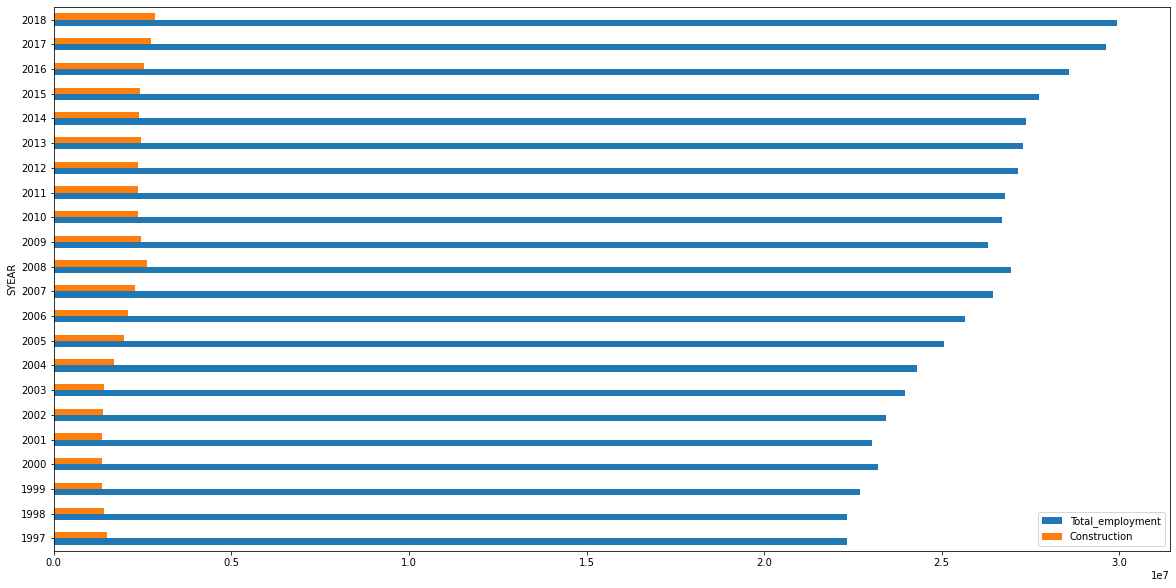

In [14]:
total_emp.plot(use_index= True, y=["Total_employment", "Construction"], kind="barh") #Horizontal bars

### TOP 5 Industries evolution through time

In [15]:
total_emp = out.groupby(['LMO_Detailed_Industry']).agg({'Employment':np.mean}).sort_values(by='Employment',ascending=False)[:5]
top5 = total_emp.reset_index()['LMO_Detailed_Industry'].to_list()
top5

['Other retail trade (excluding cars and personal care) ',
 'Construction',
 'Food services and drinking places',
 'Repair, personal and non-profit services',
 'Business, building and other support services']

In [16]:
total_emp =  out.groupby('SYEAR').agg({'Employment':sum})
for indust in top5:
    total_emp[indust] = out[out.LMO_Detailed_Industry == indust].groupby('SYEAR').agg({'Employment':sum})
total_emp.head()

,Employment,Other retail trade (excluding cars and personal care),Construction,Food services and drinking places,"Repair, personal and non-profit services","Business, building and other support services"
SYEAR,,,,,,
1997,22337000,2450000,1489750,1327750,1086750,743750
1998,22347250,2498750,1424750,1358250,1107500,782250
1999,22697000,2467000,1363500,1375000,1266750,777500
2000,23217250,2566750,1345750,1412250,1179000,836250
2001,23041250,2523750,1347250,1439750,1183250,846250


<AxesSubplot:xlabel='SYEAR'>

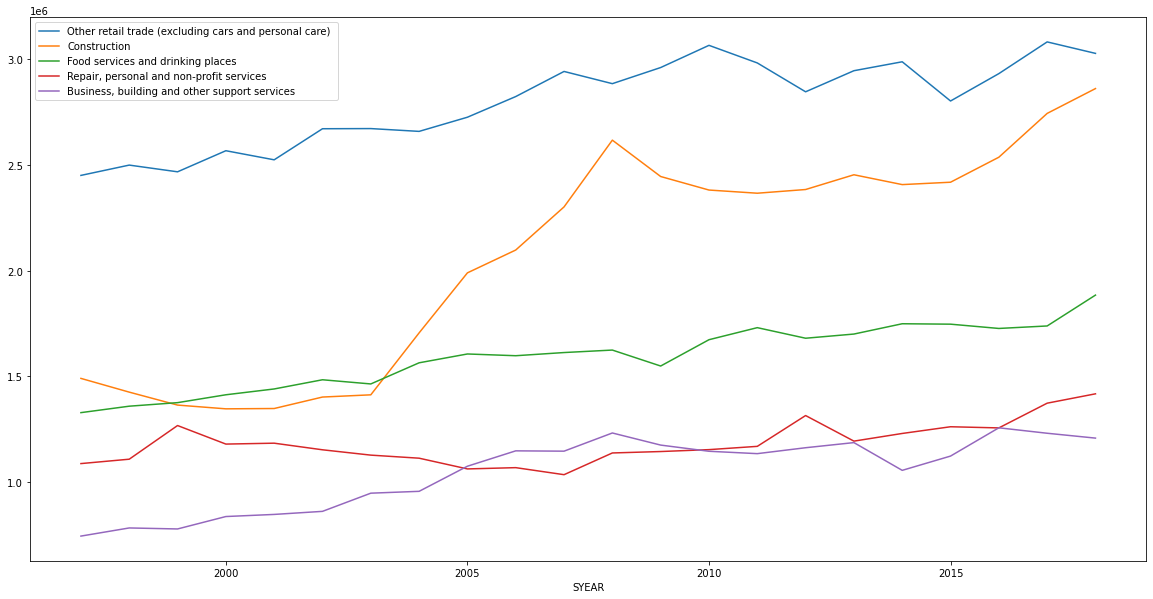

In [17]:
total_emp.plot(use_index= True, y=total_emp.columns[1:], kind="line") #Horizontal bars

### Bottom 5 industries through time.

<AxesSubplot:xlabel='SYEAR'>

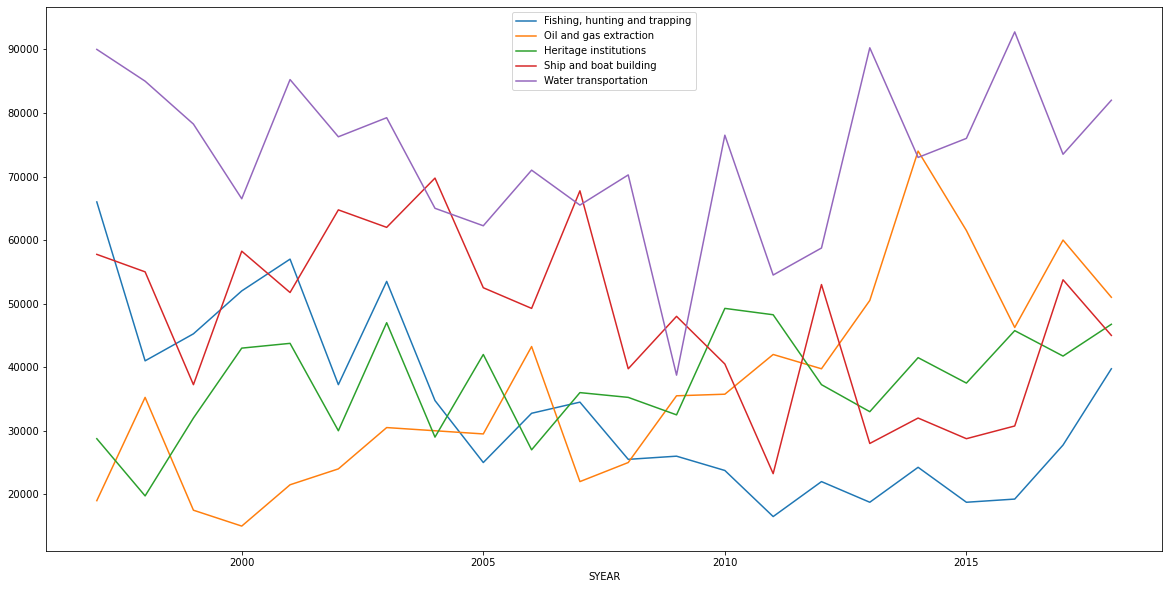

In [18]:
total_emp = out.groupby(['LMO_Detailed_Industry']).agg({'Employment':np.mean}).sort_values(by='Employment',ascending=True)[:5]
bottom5 = total_emp.reset_index()['LMO_Detailed_Industry'].to_list()
bottom5
total_emp =  out.groupby('SYEAR').agg({'Employment':sum})
for indust in bottom5:
    total_emp[indust] = out[out.LMO_Detailed_Industry == indust].groupby('SYEAR').agg({'Employment':sum})
total_emp.head()
total_emp.plot(use_index= True, y=total_emp.columns[1:], kind="line") #Horizontal bars

### THE FOOD AND RETAIL SERVICES

<AxesSubplot:xlabel='SYEAR'>

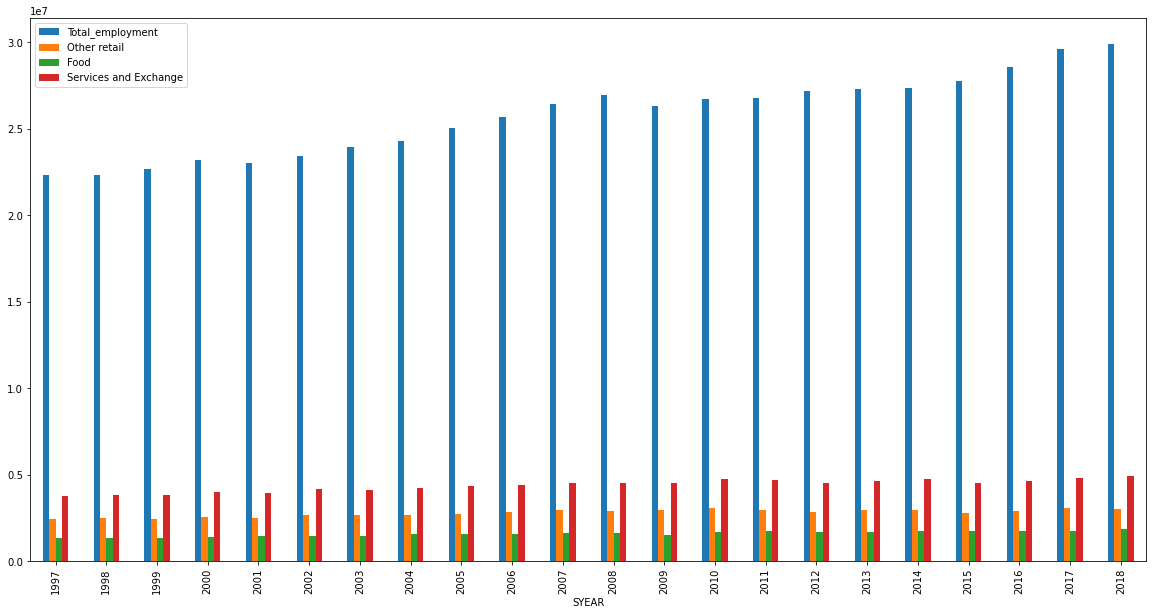

In [19]:
total_emp = out.groupby('SYEAR').agg({'Employment':sum})
total_emp['Other retail'] = out[out.LMO_Detailed_Industry == 'Other retail trade (excluding cars and personal care) '].groupby('SYEAR').agg({'Employment':sum})
total_emp['Food'] = out[out.LMO_Detailed_Industry == 'Food services and drinking places'].groupby('SYEAR').agg({'Employment':sum})
total_emp['Services and Exchange'] = total_emp['Other retail'] + total_emp['Food']
total_emp = total_emp.rename(columns={'Employment':'Total_employment'})
total_emp.plot(use_index= True, y=total_emp.columns, kind="bar") #Horizontal bars
#total_emp

### Let's switch the interest to the environment, how is foresting evolving employment-wise?

Text(0.5, 0, 'Year long evolution')

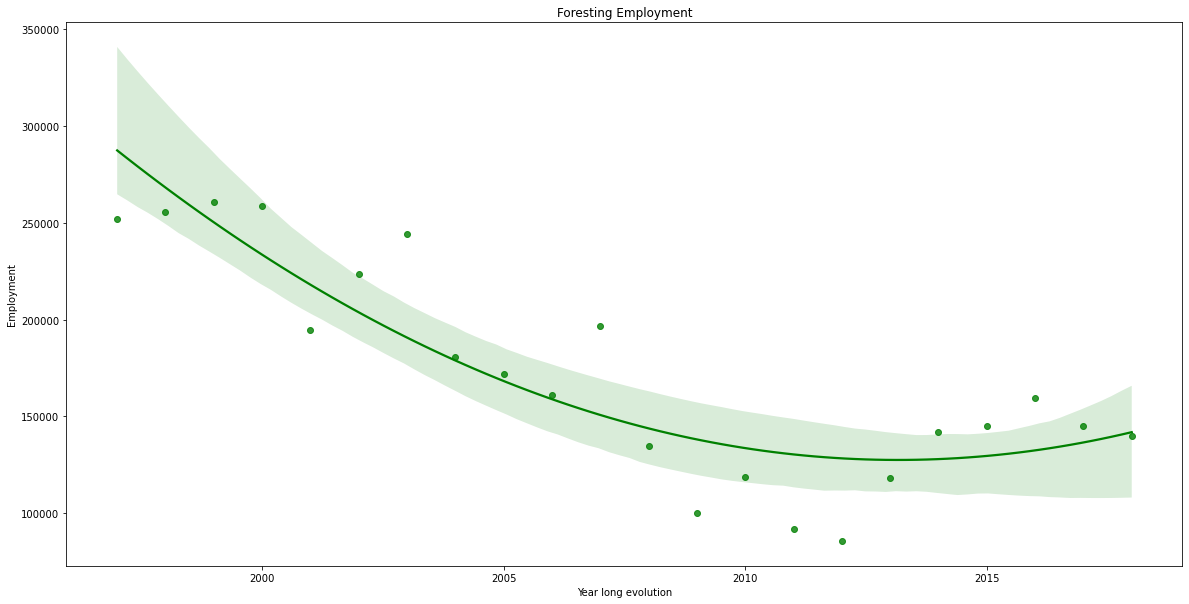

In [20]:
total_emp = out.groupby('SYEAR').agg({'Employment':sum})
total_emp['foresting'] = out[out.LMO_Detailed_Industry == 'Forestry and logging'].groupby('SYEAR').agg({'Employment':sum})
total_emp = total_emp.rename(columns={'Employment':'Total_employment'})

ax = sns.regplot(x=total_emp.index, y="foresting",order=2, data=total_emp,color='g')
ax.set_title('Foresting Employment')
ax.set_ylabel('Employment')
ax.set_xlabel('Year long evolution')

#total_emp